In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import datetime
print(f"last edit: {datetime.datetime.now()}")

last edit: 2025-07-28 10:24:02.061025


In [3]:
!nvidia-smi

Mon Jul 28 10:24:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2025-07-28 10:24:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.207, 192.178.156.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.3’

10_food_classes_10_ 100%[===================>] 160.74M  41.8MB/s    in 4.5s    

2025-07-28 10:24:06 (35.9 MB/s) - ‘10_food_classes_10_percent.zip.3’ saved [168546183/168546183]



In [5]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}")

there are 2 directories and 0 images in '10_food_classes_10_percent
there are 10 directories and 0 images in '10_food_classes_10_percent/test
there are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream
there are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi
there are 0 directories and 250 images in '10_food_classes_10_percent/test/steak
there are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice
there are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza
there are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry
there are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings
there are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen
there are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger
there are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon
there are 

In [6]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


##**Setting up callback**

In [7]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

##**Creating models using tensorflow Hub**

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

In [10]:
import tensorflow as tf
import tensorflow_hub as hub

print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow Hub version: {hub.__version__}")

TensorFlow version: 2.15.0
TensorFlow Hub version: 0.16.1


In [11]:
## https://www.tensorflow.org/hub
## https://www.kaggle.com/models?tfhub-redirect=true&owner-type=organization&datatype=14102&task=16686
## https://github.com/paperswithcode

In [12]:
# Model URLs
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# Define image shape (most TensorFlow Hub models expect 224x224)
IMAGE_SHAPE = (224, 224)

These URLs link to a saved pretrained model on TensorFlow Hub.

When we use them in our model, the model will automatically be downloaded for us to use.

To do this, we can use the [`KerasLayer()`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) model inside the TensorFlow hub library.

Since we're going to be comparing two models, to save ourselves code, we'll create a function `create_model()`. This function will take a model's TensorFlow Hub URL, instatiate a Keras Sequential model with the appropriate number of output layers and return the model.

The problem: **`error : Only instances of `keras.Layer` can be added to a Sequential model`** solve by two ways, I'm using way 2.

1. Try installing `tf_keras` by running `pip install tf_keras`. Then `import tf_keras` and and use `tf_keras.Sequential` instead of `tf.keras.Sequential` as shown below:
>

```
import tf_keras

mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
classifier_model = mobilenet_v2
IMAGE_SHAPE = (224, 224)

classifier = tf_keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])
```

2. Recommended:
>

```
pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0
```


> 🔑: [Full solution](https://stackoverflow.com/questions/78530756/error-only-instances-of-keras-layer-can-be-added-to-a-sequential-model)




In [15]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

In [16]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [17]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20250728-102515
Epoch 1/5
24/24 [==============================] - 319s 13s/step - loss: 1.9957 - accuracy: 0.3253 - val_loss: 1.2349 - val_accuracy: 0.6164
Epoch 2/5
24/24 [==============================] - 306s 13s/step - loss: 0.9235 - accuracy: 0.7240 - val_loss: 0.8898 - val_accuracy: 0.7188
Epoch 3/5
24/24 [==============================] - 312s 13s/step - loss: 0.6398 - accuracy: 0.8267 - val_loss: 0.7641 - val_accuracy: 0.7660
Epoch 4/5
24/24 [==============================] - 333s 14s/step - loss: 0.4815 - accuracy: 0.8747 - val_loss: 0.7141 - val_accuracy: 0.7744
Epoch 5/5
24/24 [==============================] - 303s 13s/step - loss: 0.3887 - accuracy: 0.9160 - val_loss: 0.7117 - val_accuracy: 0.7668


In [18]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

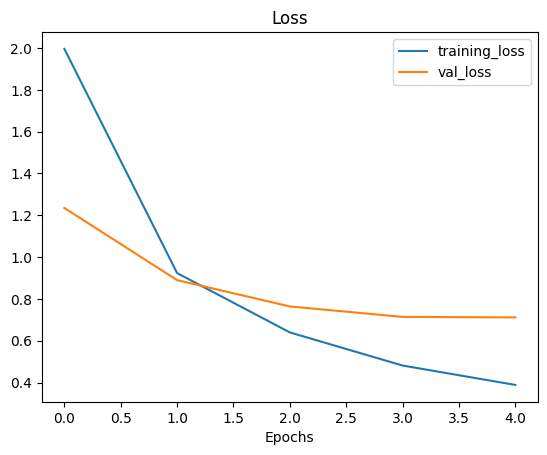

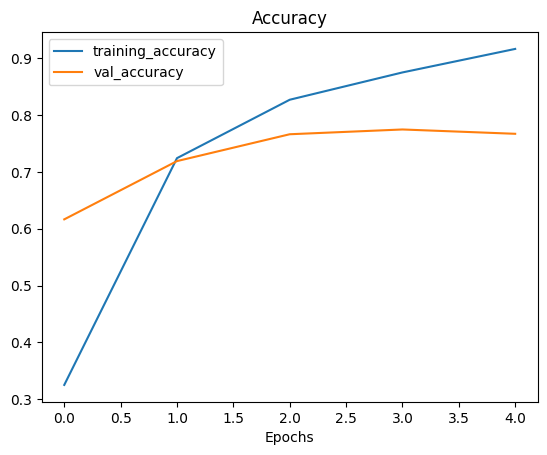

In [19]:
plot_loss_curves(resnet_history)